In [5]:
#Import the libraries
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates


import datetime
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from mplfinance.original_flavor import candlestick_ohlc

import keras
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from prophet import Prophet
from prophet.plot import plot_plotly

In [6]:
import pandas as pd

# Load the data
df_aapl = pd.read_csv('data/AAPL.csv')
df_adbe = pd.read_csv('data/ADBE.csv')
df_amd = pd.read_csv('data/AMD.csv')
df_cmcsa = pd.read_csv('data/CMCSA.csv')
df_cost = pd.read_csv('data/COST.csv')
df_intc = pd.read_csv('data/INTC.csv')
df_intu = pd.read_csv('data/INTU.csv')
df_msft = pd.read_csv('data/MSFT.csv')
df_qcom = pd.read_csv('data/QCOM.csv')
df_sbux = pd.read_csv('data/SBUX.csv')

dfs = [df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux]

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') 
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

In [7]:
def remove_before_2005(df):
    df = df[df.index.year >= 2005]
    df.reset_index(inplace=True)
    return df

dfs = [remove_before_2005(df) for df in dfs]

df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux = dfs

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def retrieve_closing_prices_only(data):
    return data[['Close']]

def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(data.values)
    return scaler, pd.DataFrame(normalized_data, columns=['Close'])

In [9]:
aapl_scaler, new_aapl_df = min_max_scaling(retrieve_closing_prices_only(df_aapl))
adbe_scaler, new_adbe_df = min_max_scaling(retrieve_closing_prices_only(df_adbe))
amd_scaler, new_amd_df = min_max_scaling(retrieve_closing_prices_only(df_amd))
cmcsa_scaler, new_cmcsa_df = min_max_scaling(retrieve_closing_prices_only(df_cmcsa))
cost_scaler, new_cost_df = min_max_scaling(retrieve_closing_prices_only(df_cost))
intc_scaler, new_intc_df = min_max_scaling(retrieve_closing_prices_only(df_intc))
intu_scaler, new_intu_df = min_max_scaling(retrieve_closing_prices_only(df_intu))
msft_scaler, new_msft_df = min_max_scaling(retrieve_closing_prices_only(df_msft))
qcom_scaler, new_qcom_df = min_max_scaling(retrieve_closing_prices_only(df_qcom))
sbux_scaler, new_sbux_df = min_max_scaling(retrieve_closing_prices_only(df_sbux))


In [10]:
new_aapl_df.head()


,Close
0,0.000000
1,0.000064
2,0.000119
3,0.000124
4,0.000588


In [11]:
import numpy as np

def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
    
    train_size = int(np.ceil(len(dataframe) * 0.90))
    test_size = int(np.ceil(len(dataframe) * 0.10))
    
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    data_array = dataframe['Close'].values
    
    train_data = data_array[0: train_size]
    test_data = data_array[train_size - prediction_days: train_size + test_size]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i])
        y_train.append(train_data[i])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i])
        y_test.append(test_data[i])
          
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    print(f'Data for {company.title()} split successfully')
    
    return X_train, y_train, X_test, y_test

In [12]:
X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl = split_and_reshape_data(new_aapl_df, 30, 'Apple')
X_train_adbe, y_train_adbe, X_test_adbe, y_test_adbe = split_and_reshape_data(new_adbe_df, 30, 'Adobe')
X_train_amd, y_train_amd, X_test_amd, y_test_amd = split_and_reshape_data(new_amd_df, 30, 'AMD')
X_train_cmcsa, y_train_cmcsa, X_test_cmcsa, y_test_cmcsa = split_and_reshape_data(new_cmcsa_df, 30, 'Comcast')
X_train_cost, y_train_cost, X_test_cost, y_test_cost = split_and_reshape_data(new_cost_df, 30, 'Costco')
X_train_intc, y_train_intc, X_test_intc, y_test_intc = split_and_reshape_data(new_intc_df, 30, 'Intel')
X_train_intu, y_train_intu, X_test_intu, y_test_intu = split_and_reshape_data(new_intu_df, 30, 'Intuit')
X_train_msft, y_train_msft, X_test_msft, y_test_msft = split_and_reshape_data(new_msft_df, 30, 'Microsoft')
X_train_qcom, y_train_qcom, X_test_qcom, y_test_qcom = split_and_reshape_data(new_qcom_df, 30, 'Qualcomm')
X_train_sbux, y_train_sbux, X_test_sbux, y_test_sbux = split_and_reshape_data(new_sbux_df, 30, 'Starbucks')


The training size for Apple is 4067 rows
The testing size for Apple is 452 rows
Data for Apple split successfully
The training size for Adobe is 4067 rows
The testing size for Adobe is 452 rows
Data for Adobe split successfully
The training size for Amd is 4067 rows
The testing size for Amd is 452 rows
Data for Amd split successfully
The training size for Comcast is 4067 rows
The testing size for Comcast is 452 rows
Data for Comcast split successfully
The training size for Costco is 4067 rows
The testing size for Costco is 452 rows
Data for Costco split successfully
The training size for Intel is 4067 rows
The testing size for Intel is 452 rows
Data for Intel split successfully
The training size for Intuit is 4067 rows
The testing size for Intuit is 452 rows
Data for Intuit split successfully
The training size for Microsoft is 4067 rows
The testing size for Microsoft is 452 rows
Data for Microsoft split successfully
The training size for Qualcomm is 4067 rows
The testing size for Qualc

# Dense

Epoch 1/50
127/127 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 2/50
127/127 [==============================] - 0s 823us/step - loss: 0.0021 - val_loss: 0.0149
Epoch 3/50
127/127 [==============================] - 0s 835us/step - loss: 0.0018 - val_loss: 0.0054
Epoch 4/50
127/127 [==============================] - 0s 863us/step - loss: 0.0015 - val_loss: 0.0036
Epoch 5/50
127/127 [==============================] - 0s 847us/step - loss: 0.0015 - val_loss: 0.0033
Epoch 6/50
127/127 [==============================] - 0s 847us/step - loss: 0.0014 - val_loss: 0.0115
Epoch 7/50
127/127 [==============================] - 0s 827us/step - loss: 0.0011 - val_loss: 0.0113
Epoch 8/50
127/127 [==============================] - 0s 825us/step - loss: 0.0011 - val_loss: 0.0313
Epoch 9/50
127/127 [==============================] - 0s 808us/step - loss: 0.0011 - val_loss: 0.0251
Epoch 10/50
15/15 [==============================] - 0s 498us/step
The MSE for Apple

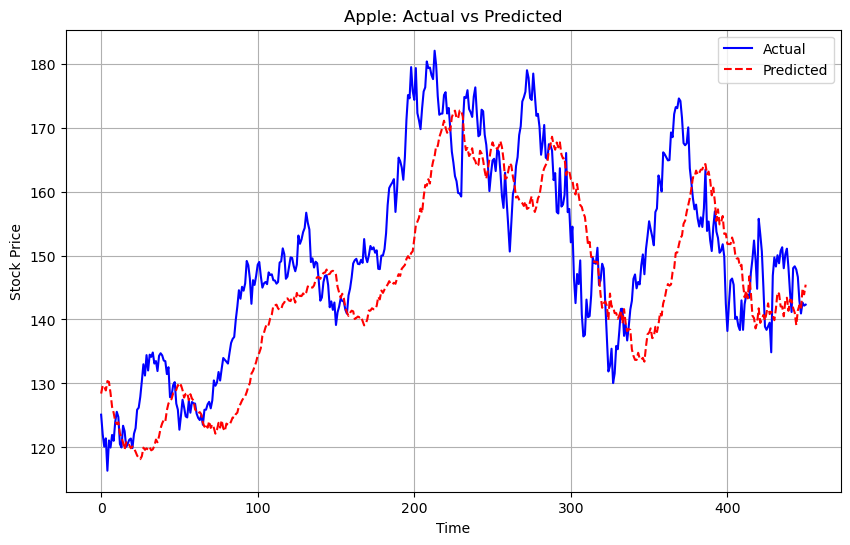

Training completed for Apple. MSE: 0.003273692694468166
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0072
Epoch 2/50
127/127 [==============================] - 0s 799us/step - loss: 0.0020 - val_loss: 0.0072
Epoch 3/50
127/127 [==============================] - 0s 810us/step - loss: 0.0017 - val_loss: 0.0128
Epoch 4/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 5/50
127/127 [==============================] - 0s 815us/step - loss: 0.0014 - val_loss: 0.0050
Epoch 6/50
127/127 [==============================] - 0s 791us/step - loss: 0.0015 - val_loss: 0.0114
Epoch 7/50
127/127 [==============================] - 0s 820us/step - loss: 0.0015 - val_loss: 0.0076
Epoch 8/50
127/127 [==============================] - 0s 809us/step - loss: 0.0013 - val_loss: 0.0118
Epoch 9/50
127/127 [==============================] - 0s 792us/step - loss: 0.0013 - val_loss: 0.0067
Epoch 10/50
15/15 [===========

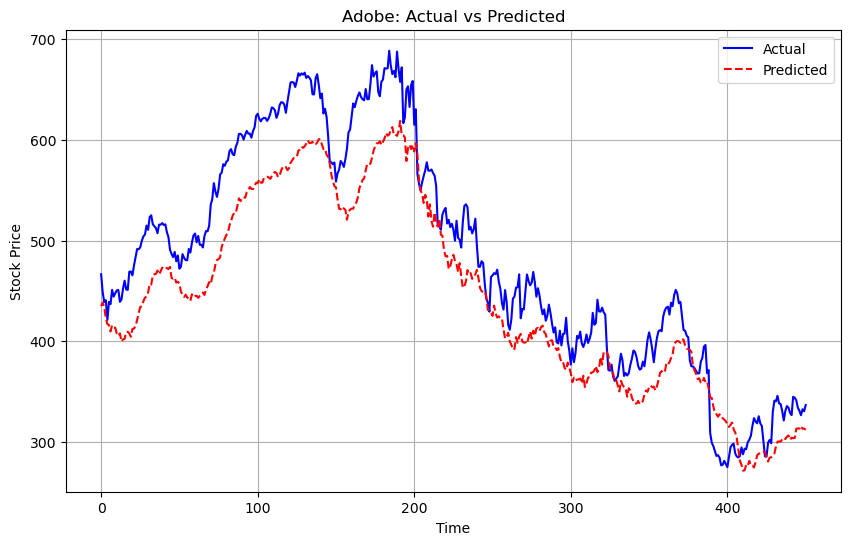

Training completed for Adobe. MSE: 0.005011849133165803
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0059
Epoch 2/50
127/127 [==============================] - 0s 815us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 3/50
127/127 [==============================] - 0s 831us/step - loss: 0.0011 - val_loss: 0.0029
Epoch 4/50
127/127 [==============================] - 0s 815us/step - loss: 9.4855e-04 - val_loss: 0.0029
Epoch 5/50
127/127 [==============================] - 0s 823us/step - loss: 9.6707e-04 - val_loss: 0.0034
Epoch 6/50
127/127 [==============================] - 0s 815us/step - loss: 8.5731e-04 - val_loss: 0.0026
Epoch 7/50
127/127 [==============================] - 0s 807us/step - loss: 8.4173e-04 - val_loss: 0.0041
Epoch 8/50
127/127 [==============================] - 0s 807us/step - loss: 7.9170e-04 - val_loss: 0.0026
Epoch 9/50
127/127 [==============================] - 0s 1ms/step - loss: 8.1004e-04 - val_loss: 0.0022
Epoch 

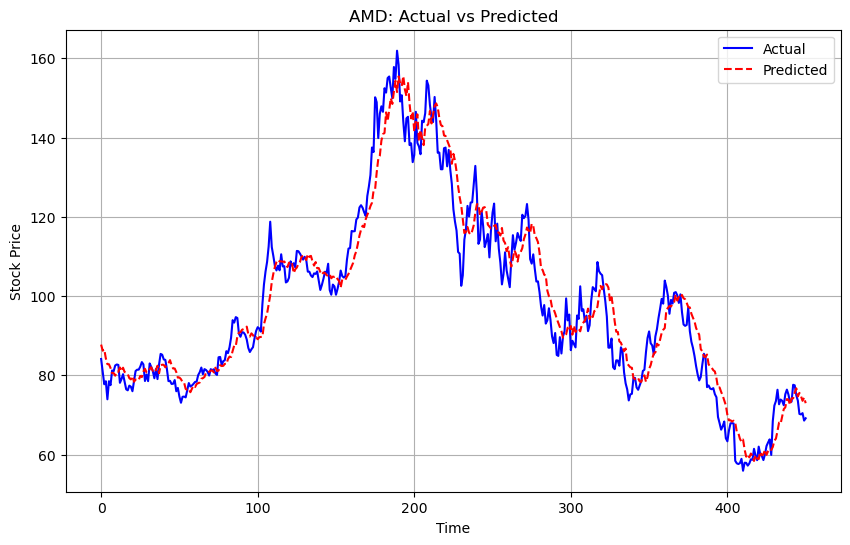

Training completed for AMD. MSE: 0.0014541268283054258
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0070
Epoch 2/50
127/127 [==============================] - 0s 823us/step - loss: 0.0053 - val_loss: 0.0070
Epoch 3/50
127/127 [==============================] - 0s 829us/step - loss: 0.0041 - val_loss: 0.0081
Epoch 4/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0157
Epoch 5/50
127/127 [==============================] - 0s 846us/step - loss: 0.0027 - val_loss: 0.0117
Epoch 6/50
127/127 [==============================] - 0s 849us/step - loss: 0.0025 - val_loss: 0.0101
Epoch 7/50
15/15 [==============================] - 0s 515us/step
The MSE for Comcast with Dense NN is 0.007023996622436329


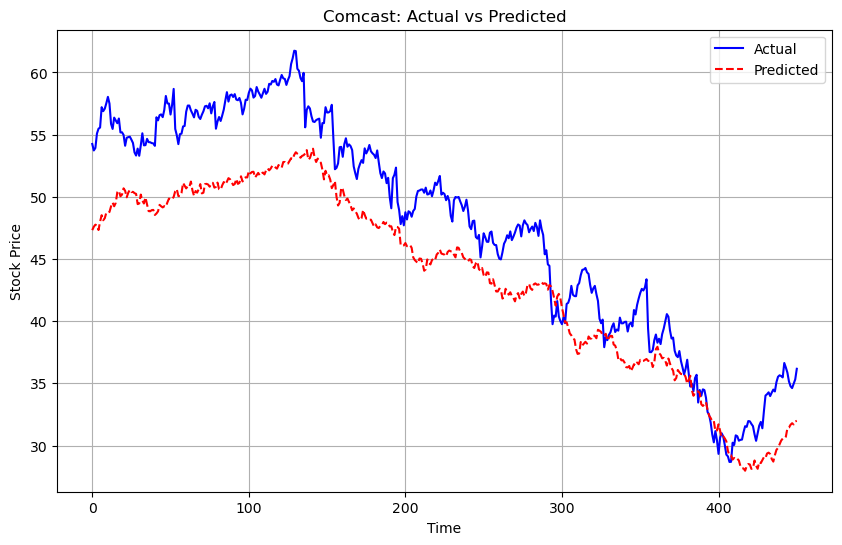

Training completed for Comcast. MSE: 0.007023996622436329
Epoch 1/50
127/127 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0118
Epoch 2/50
127/127 [==============================] - 0s 886us/step - loss: 0.0016 - val_loss: 0.0142
Epoch 3/50
127/127 [==============================] - 0s 878us/step - loss: 0.0013 - val_loss: 0.0138
Epoch 4/50
127/127 [==============================] - 0s 862us/step - loss: 0.0012 - val_loss: 0.0187
Epoch 5/50
127/127 [==============================] - 0s 871us/step - loss: 0.0011 - val_loss: 0.0085
Epoch 6/50
127/127 [==============================] - 0s 878us/step - loss: 9.4481e-04 - val_loss: 0.0144
Epoch 7/50
127/127 [==============================] - 0s 847us/step - loss: 9.4385e-04 - val_loss: 0.0072
Epoch 8/50
127/127 [==============================] - 0s 856us/step - loss: 9.3442e-04 - val_loss: 0.0210
Epoch 9/50
127/127 [==============================] - 0s 856us/step - loss: 8.6091e-04 - val_loss: 0.0154
Epoch 10/5

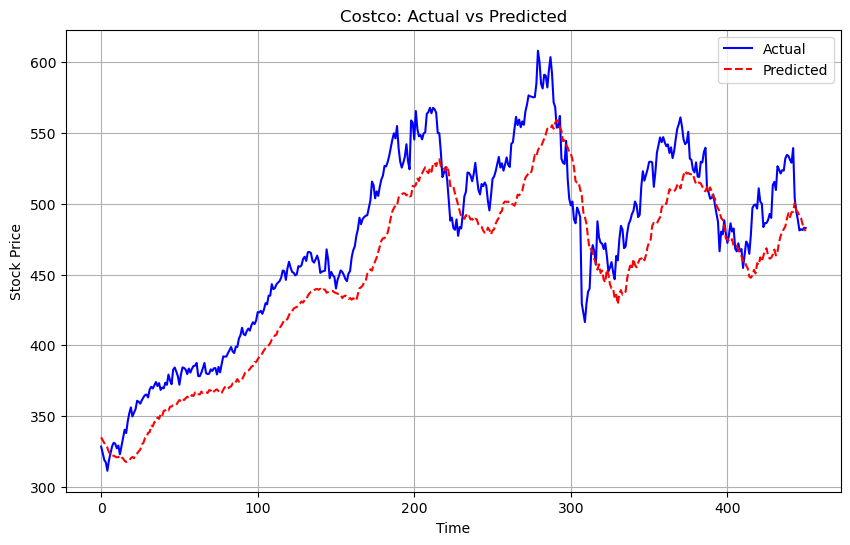

Training completed for Costco. MSE: 0.0030943576872454214
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0173 - val_loss: 0.0016
Epoch 2/50
127/127 [==============================] - 0s 854us/step - loss: 0.0058 - val_loss: 0.0028
Epoch 3/50
127/127 [==============================] - 0s 916us/step - loss: 0.0040 - val_loss: 0.0029
Epoch 4/50
127/127 [==============================] - 0s 855us/step - loss: 0.0033 - val_loss: 0.0020
Epoch 5/50
127/127 [==============================] - 0s 863us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 6/50
127/127 [==============================] - 0s 842us/step - loss: 0.0031 - val_loss: 7.0495e-04
Epoch 7/50
127/127 [==============================] - 0s 851us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/50
127/127 [==============================] - 0s 859us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 9/50
127/127 [==============================] - 0s 867us/step - loss: 0.0026 - val_loss: 0.0034
Epoch 10/50
127/127 [=

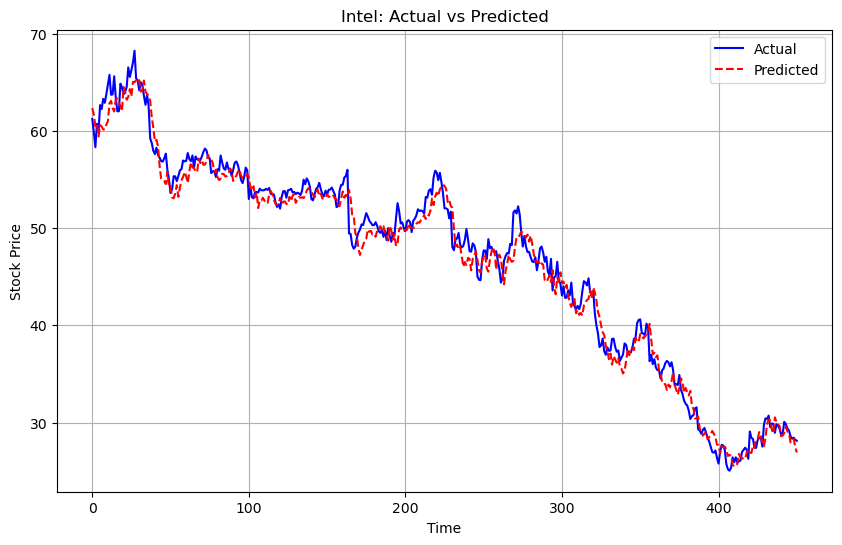

Training completed for Intel. MSE: 0.0007049478835760645
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 2/50
127/127 [==============================] - 0s 807us/step - loss: 0.0013 - val_loss: 0.0020
Epoch 3/50
127/127 [==============================] - 0s 799us/step - loss: 0.0010 - val_loss: 0.0052
Epoch 4/50
127/127 [==============================] - 0s 807us/step - loss: 8.7092e-04 - val_loss: 0.0013
Epoch 5/50
127/127 [==============================] - 0s 801us/step - loss: 7.7863e-04 - val_loss: 0.0022
Epoch 6/50
127/127 [==============================] - 0s 809us/step - loss: 7.7021e-04 - val_loss: 0.0012
Epoch 7/50
127/127 [==============================] - 0s 807us/step - loss: 7.3399e-04 - val_loss: 0.0068
Epoch 8/50
127/127 [==============================] - 0s 1ms/step - loss: 7.2803e-04 - val_loss: 0.0022
Epoch 9/50
127/127 [==============================] - 0s 797us/step - loss: 6.9284e-04 - val_loss: 0.0032
Epoch

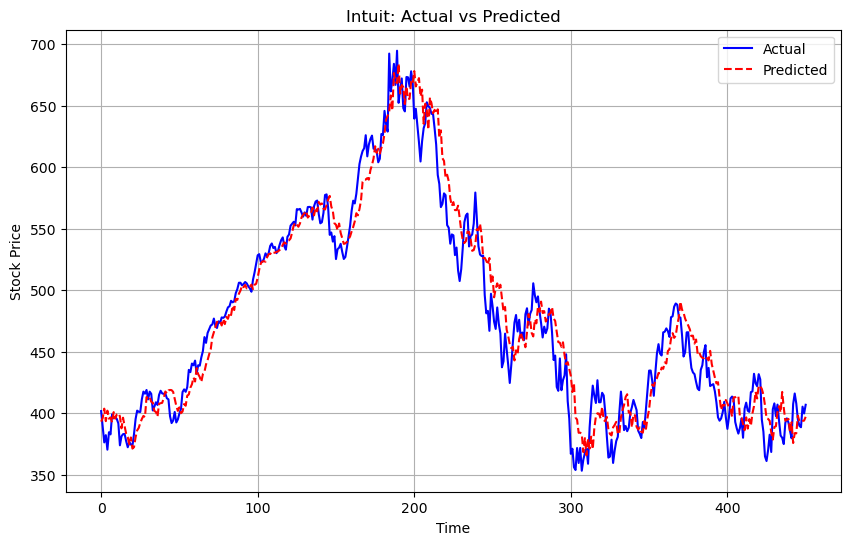

Training completed for Intuit. MSE: 0.0008906800375392149
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0080
Epoch 2/50
127/127 [==============================] - 0s 807us/step - loss: 0.0016 - val_loss: 0.0033
Epoch 3/50
127/127 [==============================] - 0s 810us/step - loss: 0.0011 - val_loss: 0.0052
Epoch 4/50
127/127 [==============================] - 0s 807us/step - loss: 0.0012 - val_loss: 0.0070
Epoch 5/50
127/127 [==============================] - 0s 864us/step - loss: 0.0010 - val_loss: 0.0143
Epoch 6/50
127/127 [==============================] - 0s 794us/step - loss: 0.0011 - val_loss: 0.0148
Epoch 7/50
15/15 [==============================] - 0s 569us/step
The MSE for Microsoft with Dense NN is 0.0033405749890438293


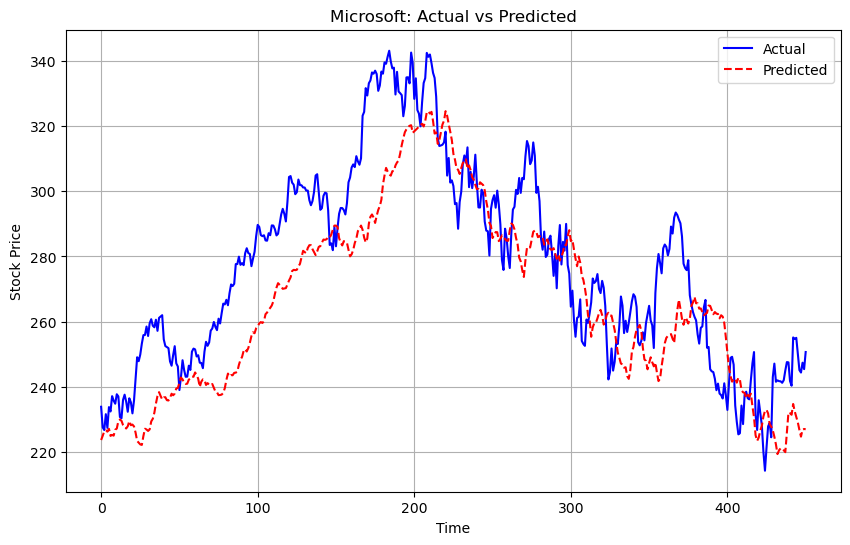

Training completed for Microsoft. MSE: 0.0033405749890438293
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0074
Epoch 2/50
127/127 [==============================] - 0s 823us/step - loss: 0.0024 - val_loss: 0.0131
Epoch 3/50
127/127 [==============================] - 0s 831us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/50
127/127 [==============================] - 0s 795us/step - loss: 0.0016 - val_loss: 0.0086
Epoch 5/50
127/127 [==============================] - 0s 807us/step - loss: 0.0014 - val_loss: 0.0096
Epoch 6/50
127/127 [==============================] - 0s 815us/step - loss: 0.0012 - val_loss: 0.0234
Epoch 7/50
127/127 [==============================] - 0s 793us/step - loss: 0.0012 - val_loss: 0.0101
Epoch 8/50
15/15 [==============================] - 0s 498us/step
The MSE for Qualcomm with Dense NN is 0.0019919227899637022


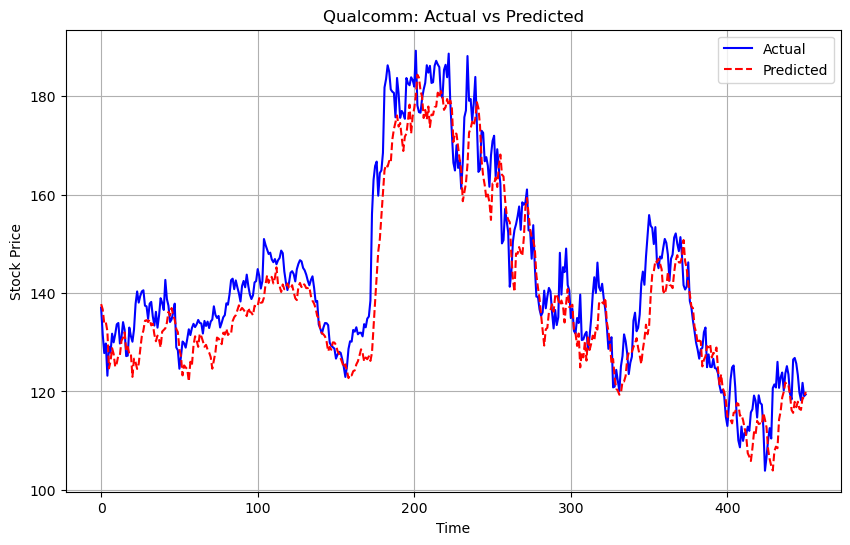

Training completed for Qualcomm. MSE: 0.0019919227899637022
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0429 - val_loss: 0.0067
Epoch 2/50
127/127 [==============================] - 0s 803us/step - loss: 0.0084 - val_loss: 0.0215
Epoch 3/50
127/127 [==============================] - 0s 811us/step - loss: 0.0061 - val_loss: 0.0107
Epoch 4/50
127/127 [==============================] - 0s 804us/step - loss: 0.0048 - val_loss: 0.0211
Epoch 5/50
127/127 [==============================] - 0s 791us/step - loss: 0.0044 - val_loss: 0.0072
Epoch 6/50
15/15 [==============================] - 0s 498us/step
The MSE for Starbucks with Dense NN is 0.006702260354131305


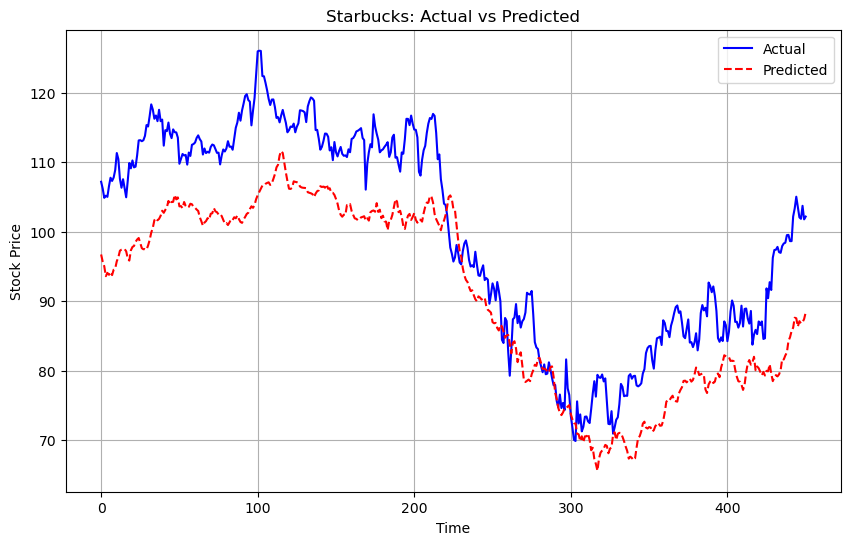

Training completed for Starbucks. MSE: 0.006702260354131305

Aggregate MSE for Dense Neural Network models across all stocks:  0.003348840901987526

Mean MSE for Dense Neural Network model:  0.003348840901987526


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def create_dense_nn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

def plot_predictions_vs_truth(y_test, y_pred, company_name, scaler):
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'{company_name}: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to get predictions, calculate MSE, and plot the results
def predictions_dense_mse(company, model, X_test, y_test, scaler):
    global mse_dense_sum
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_dense_sum += mse
    
    print(f'The MSE for {company} with Dense NN is {mse}')
    plot_predictions_vs_truth(y_test, y_pred, company, scaler)
    
    return mse

nn_models = {}
history_records = {}
mse_results = {
    'Dense': {}
}
mse_dense_sum = 0
mse_list = []

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

stocks_data = {
    'Apple': (X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl, aapl_scaler),
    'Adobe': (X_train_adbe, X_test_adbe, y_train_adbe, y_test_adbe, adbe_scaler),
    'AMD': (X_train_amd, X_test_amd, y_train_amd, y_test_amd, amd_scaler),
    'Comcast': (X_train_cmcsa, X_test_cmcsa, y_train_cmcsa, y_test_cmcsa, cmcsa_scaler),
    'Costco': (X_train_cost, X_test_cost, y_train_cost, y_test_cost, cost_scaler),
    'Intel': (X_train_intc, X_test_intc, y_train_intc, y_test_intc, intc_scaler),
    'Intuit': (X_train_intu, X_test_intu, y_train_intu, y_test_intu, intu_scaler),
    'Microsoft': (X_train_msft, X_test_msft, y_train_msft, y_test_msft, msft_scaler),
    'Qualcomm': (X_train_qcom, X_test_qcom, y_train_qcom, y_test_qcom, qcom_scaler),
    'Starbucks': (X_train_sbux, X_test_sbux, y_train_sbux, y_test_sbux, sbux_scaler)
}

for company, data in stocks_data.items():
    X_train, X_test, y_train, y_test, scaler = data
    
    model = create_dense_nn_model(X_train.shape[1])
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])
    
    nn_models[company] = model
    history_records[company] = history

    mse = predictions_dense_mse(company, model, X_test, y_test, scaler)
    
    mse_results['Dense'][company] = mse
    mse_list.append(mse)

    print(f"Training completed for {company}. MSE: {mse}")

mse_dense = mse_dense_sum / len(stocks_data)
print("\nAggregate MSE for Dense Neural Network models across all stocks: ", mse_dense)

mse_dense = np.mean(mse_list)
print("\nMean MSE for Dense Neural Network model: ", mse_dense)


In [14]:
mse_dense

0.003348840901987526

In [17]:
mse_results_dense=mse_list

In [18]:
mse_results_dense

[0.003273692694468166,
 0.005011849133165803,
 0.0014541268283054258,
 0.007023996622436329,
 0.0030943576872454214,
 0.0007049478835760645,
 0.0008906800375392149,
 0.0033405749890438293,
 0.0019919227899637022,
 0.006702260354131305]

In [19]:
import pickle

# Save the mse_results dictionary and mse_dense value to a file
with open('mse_results_and_dense.pkl', 'wb') as file:
    pickle.dump({'mse_results_dense': mse_results_dense, 'mse_dense': mse_dense}, file)

print("mse_results and mse_dense have been saved to mse_results_and_dense.pkl")


mse_results and mse_dense have been saved to mse_results_and_dense.pkl
